In [1]:
import pandas as pd
import utils
import matplotlib.pyplot as plt
import random
import plotly.express as px

random.seed(9000)

plt.style.use("seaborn-ticks")
plt.rcParams["image.cmap"] = "Set1"
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set1.colors)
%matplotlib inline

In this notebook we calculate Percent Replicating to measure of the proportion of perturbations with detectable signature. The following are the steps taken

- Normalized, feature selected profiles are read and the replicate plates are merged into a single dataframe.
- Separate data frames are created for each concentration and all the following steps are repeated for each data frame
    - Negative control, Positive control and empty wells are removed from the dataframe.
    - The signal distribution, which is the median pairwise replicate correlation, is computed for each replicate.
    - The null distribution, which is the median pairwise correlation of non-replicates, is computed for 1000 combinations of non-replicates.
    - Percent Replicating is computed as the percentage of the signal distribution that is the greater than the 95th percentile of null distribution.
    - The signal and noise distributions and the Percent Replicating values are plotted and the table of Percent Replicating is printed.
- A single table with replicate correlations at both concentration is printed.
- A scatter plot of replicate correlations at the two concentrations is plotted.

In [2]:
experiment_df = pd.read_csv('output/experiment-metadata.tsv', sep='\t')

corr_replicating_df = pd.DataFrame()
group_by_feature = 'Metadata_broad_sample'
n_replicates = experiment_df.shape[0]
n_samples = 1000

In [3]:
all_plates_df = pd.DataFrame()

for i, plate in enumerate(experiment_df.Assay_Plate_Barcode.unique()):
    batch = experiment_df.loc[i, 'Batch']
    df = (
        pd.read_csv(f'../profiles/{batch}/{plate}/{plate}_normalized_feature_select_negcon_batch.csv.gz')
    )
    all_plates_df = utils.concat_profiles(all_plates_df, df)

all_plates_df = utils.remove_all_control_empty_wells(all_plates_df)

all_plates_conc_1_df = utils.remove_all_control_empty_wells(all_plates_df.query('Metadata_mmoles_per_liter==1'))
all_plates_conc_4_df = utils.remove_all_control_empty_wells(all_plates_df.query('Metadata_mmoles_per_liter==4'))

In [4]:
replicating_corr_conc_1_df = utils.corr_between_replicates_df(all_plates_conc_1_df, group_by_feature)
replicating_corr = list(replicating_corr_conc_1_df.replicate_correlation)
null_replicating = utils.corr_between_non_replicates(all_plates_conc_1_df, n_samples=n_samples, n_replicates=n_replicates, metadata_compound_name=group_by_feature)

prop_95_replicating, value_95_replicating_conc_1 = utils.percent_score(null_replicating, replicating_corr, how='right')

corr_replicating_df = corr_replicating_df.append({'Description':"Concentration = 1 uM",
                                                  'Replicating':replicating_corr,
                                                  'Null_Replicating':null_replicating,
                                                  'Percent_Replicating':'%.1f'%prop_95_replicating,
                                                  'Value_95':value_95_replicating_conc_1}, ignore_index=True)


replicating_corr_conc_4_df = utils.corr_between_replicates_df(all_plates_conc_4_df, group_by_feature)
replicating_corr = list(replicating_corr_conc_4_df.replicate_correlation)
null_replicating = utils.corr_between_non_replicates(all_plates_conc_4_df, n_samples=n_samples, n_replicates=n_replicates, metadata_compound_name=group_by_feature)

prop_95_replicating, value_95_replicating_conc_4 = utils.percent_score(null_replicating, replicating_corr, how='right')

corr_replicating_df = corr_replicating_df.append({'Description':"Concentration = 4 uM",
                                                  'Replicating':replicating_corr,
                                                  'Null_Replicating':null_replicating,
                                                  'Percent_Replicating':'%.1f'%prop_95_replicating,
                                                  'Value_95':value_95_replicating_conc_4}, ignore_index=True)

In [5]:
print(corr_replicating_df[['Description', 'Percent_Replicating']].to_markdown(index=False))

| Description          |   Percent_Replicating |
|:---------------------|----------------------:|
| Concentration = 1 uM |                  84.7 |
| Concentration = 4 uM |                  83.3 |


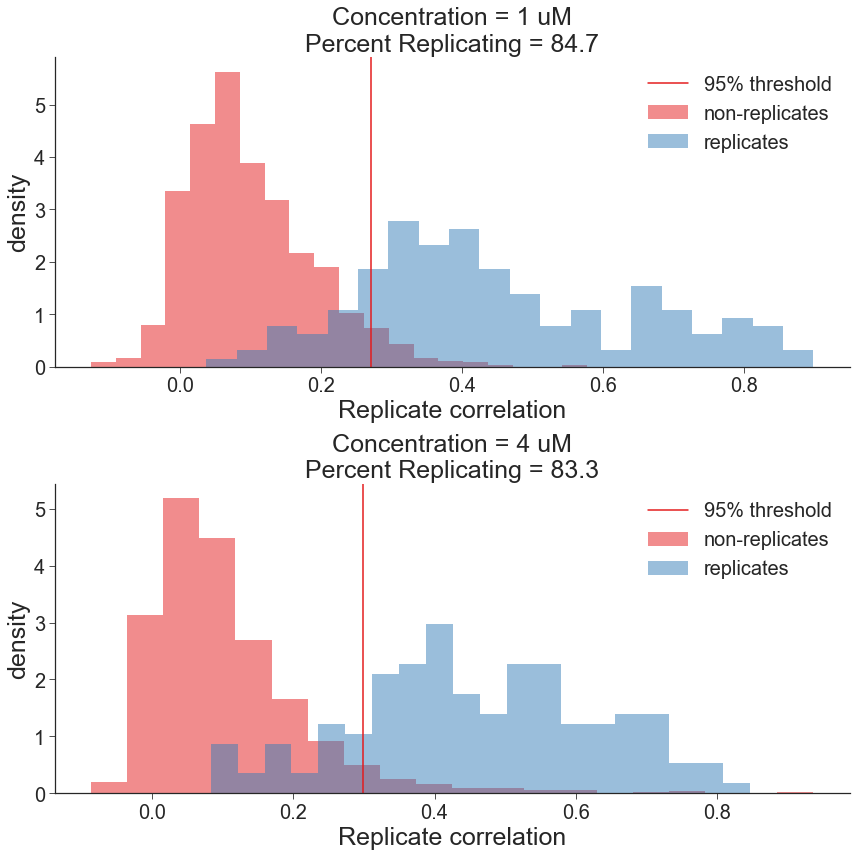

In [6]:
utils.distribution_plot(df=corr_replicating_df, output_file="2.percent_replicating.png", metric="Percent Replicating")

In [7]:
corr_df = replicating_corr_conc_1_df.merge(replicating_corr_conc_4_df, on='Metadata_broad_sample', suffixes=('_conc_1','_conc_4'))
catalog_df = all_plates_conc_1_df[['Metadata_broad_sample','Metadata_Supplier_Catalog']].copy().drop_duplicates().reset_index(drop=True)
corr_df = (
        catalog_df.merge(corr_df, on='Metadata_broad_sample', how='right')
        .sort_values(by=['replicate_correlation_conc_1','replicate_correlation_conc_4'], ascending=False)
        .reset_index(drop=True)
)

print(corr_df.to_markdown(index=False))

| Metadata_broad_sample   | Metadata_Supplier_Catalog       |   replicate_correlation_conc_1 |   replicate_correlation_conc_4 |
|:------------------------|:--------------------------------|-------------------------------:|-------------------------------:|
| BRD-U00088098-001-01-9  | VS1123                          |                      0.899068  |                      0.539145  |
| BRD-U00088039-001-01-9  | VS812                           |                      0.884921  |                      0.39496   |
| BRD-U00087978-001-01-9  | VS11 + ibrutinib-amine          |                      0.853814  |                      0.452694  |
| BRD-U00087992-001-01-9  | VS632 and nutlin                |                      0.849026  |                      0.556655  |
| BRD-U00088002-001-01-9  | VS11 and VS812                  |                      0.845501  |                      0.751529  |
| BRD-U00088025-001-01-9  | puh71 and VS985                 |                      0.826535  |          

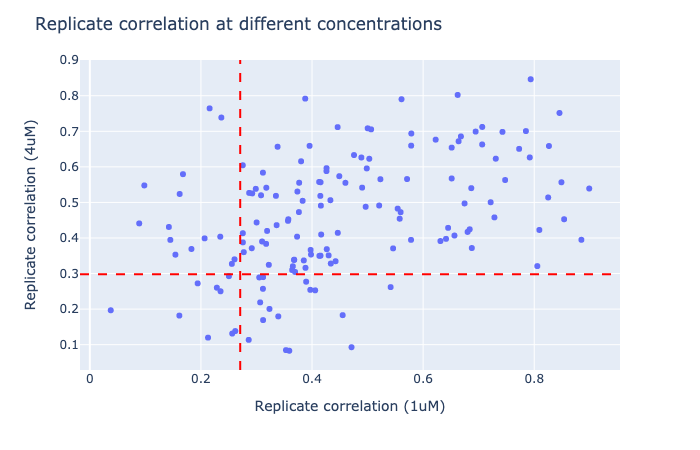

In [8]:
fig = px.scatter(data_frame=corr_df, x='replicate_correlation_conc_1', y='replicate_correlation_conc_4', hover_data=['Metadata_Supplier_Catalog'])
fig.update_layout(title='Replicate correlation at different concentrations',
                  xaxis=dict(title='Replicate correlation (1uM)'),
                  yaxis=dict(title='Replicate correlation (4uM)'))
fig.add_vline(x=value_95_replicating_conc_1, line_color='red', line_dash="dash")
fig.add_hline(y=value_95_replicating_conc_4, line_color='red', line_dash="dash")

fig.show("png")
fig.write_image('figures/2.replicate_correlation_scatter.png', height=480, width=640, scale=2)